# Image Classification

## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from PIL import Image
import io

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
print(tf.__version__)

2.17.0


In [3]:
print("Devices available: ", tf.config.list_physical_devices())
print("GPUs available: ", tf.config.list_physical_devices('GPU'))

Devices available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs available:  []


## Data Path Preparation

### Create Path

In [4]:
main_dir = 'Dataset'

In [43]:
if os.path.exists(main_dir):
    for subdir_name in os.listdir(main_dir):
        subdir_path = os.path.join(main_dir, subdir_name)

        if os.path.isdir(subdir_path):
            print(f'Memproses subdir: {subdir_path}')           

Memproses subdir: Dataset\cardboard
Memproses subdir: Dataset\e-waste
Memproses subdir: Dataset\glass
Memproses subdir: Dataset\medical
Memproses subdir: Dataset\metal
Memproses subdir: Dataset\paper
Memproses subdir: Dataset\plastic


In [44]:
data_paths = []
labels = []

class_list = os.listdir(main_dir)

for classes in class_list:
    class_path = os.path.join(main_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for file in file_list:
            f_path = os.path.join(class_path, file)
            data_paths.append(f_path)
            labels.append(classes)

In [45]:
# Path Checking

F_series = pd.Series(data_paths, name='file_paths')
L_series = pd.Series(labels, name='labels')

data_df = pd.concat([F_series, L_series], axis=1)

print(data_df.head())
print(data_df['labels'].value_counts())

                             file_paths     labels
0     Dataset\cardboard\cardboard 1.jpg  cardboard
1    Dataset\cardboard\cardboard 10.jpg  cardboard
2   Dataset\cardboard\cardboard 100.jpg  cardboard
3  Dataset\cardboard\cardboard 1000.jpg  cardboard
4  Dataset\cardboard\cardboard 1001.jpg  cardboard
labels
e-waste      2405
paper        2155
plastic      2135
metal        2068
glass        2022
cardboard    1929
medical      1565
Name: count, dtype: int64


## Data Split

In [8]:
train_size = 0.8 
test_size = 0.2

In [9]:
train_set, test_set = train_test_split(data_df, test_size=test_size, shuffle=True, stratify=data_df['labels'], random_state=42)

print('train_set length:', len(train_set), 'test_set length:', len(test_set))


train_set length: 11425 test_set length: 2857


## Preprocessing

### Standarisasi

In [34]:
def get_image_size(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size  # (width, height)
    except Exception as e:
        print(f"Error opening image {filepath}: {e}")
        return None

def find_smallest_image(directory):
    smallest_image = None
    smallest_size = None

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        size = get_image_size(filepath)
        
        if size:
            if smallest_size is None or (size[0] * size[1] < smallest_size[0] * smallest_size[1]):
                smallest_size = size
                smallest_image = filepath
    
    return smallest_image, smallest_size

In [35]:
smallest_image, smallest_size = find_smallest_image(subdir_path)

if smallest_image:
    print(f"The smallest image is {smallest_image} with size {smallest_size}")
else:
    print("No valid images found.")

The smallest image is Dataset\plastic\plastic 1992.jpg with size (125, 125)


In [36]:
# Standarisasi Data
height = 125
width = 125
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

### Augmentation

In [37]:
train_datagen = ImageDataGenerator(
    rescale= 1./255.,
    rotation_range= 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode= 'nearest'
)

In [38]:
# Train Data
train_gen = train_datagen.flow_from_dataframe(train_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 11422 validated image filenames belonging to 7 classes.


c:\Users\ACER\.conda\envs\ImageClassy\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="file_paths". These filename(s) will be ignored.
  warnings.warn(


In [39]:
test_datagen = ImageDataGenerator(
    rescale= 1./255.
)

In [40]:
# Test Data
test_gen = test_datagen.flow_from_dataframe(test_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 2857 validated image filenames belonging to 7 classes.


In [41]:
train_categories = list(train_gen.class_indices.keys())
print(train_categories)

['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


## Data Checking

### Show Images

In [26]:
from PIL import UnidentifiedImageError

def open_image(image_path):
    try:
        with Image.open(image_path) as img:
            # Gambar berhasil dikenali, tidak melakukan apa-apa
            pass
    except UnidentifiedImageError:
        print(f"File {image_path} tidak dikenali atau rusak. Menghapus file.")
        os.remove(image_path)
    except Exception as e:
        print(f"Terjadi kesalahan saat membuka {image_path}: {e}")

def process_images_in_folder(root_folder):
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):  # Tambahkan format gambar yang diperlukan
                open_image(file_path)

# Ganti dengan path folder root Anda
root_folder_path = 'Dataset'
process_images_in_folder(root_folder_path)

File Dataset\cardboard\cardboard 1075.jpg tidak dikenali atau rusak. Menghapus file.
File Dataset\e-waste\e-waste 1719.jpg tidak dikenali atau rusak. Menghapus file.
File Dataset\paper\paper 2273.jpg tidak dikenali atau rusak. Menghapus file.


In [27]:
def show_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize= (20, 20))
    for i in range(min(len(labels), 20)):
        plt.subplot(5, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = train_categories[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [46]:
print(data_df['labels'].value_counts())

labels
e-waste      2405
paper        2155
plastic      2135
metal        2068
glass        2022
cardboard    1929
medical      1565
Name: count, dtype: int64


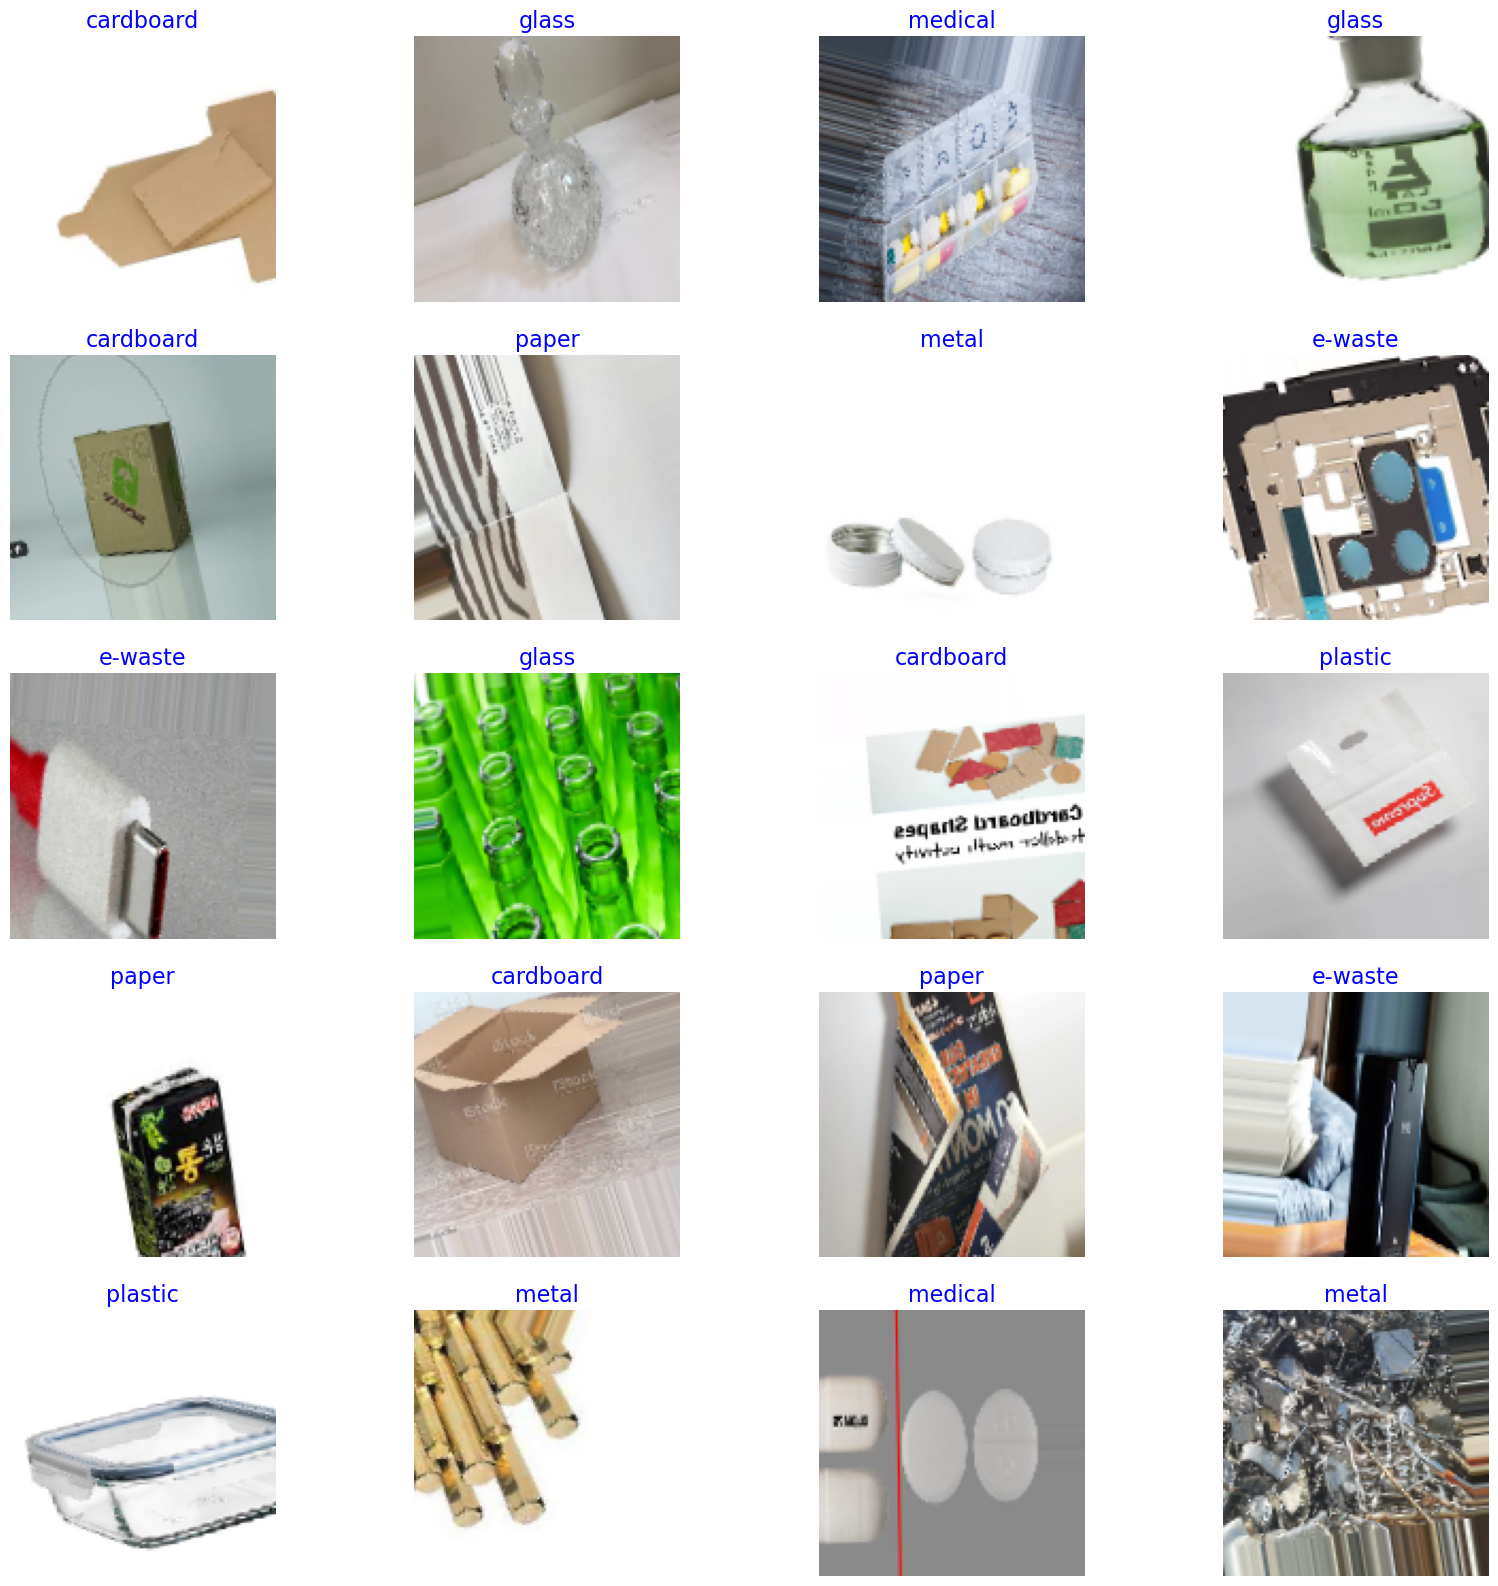

In [47]:
show_samples(train_gen)

### Convert Image

In [33]:
def convert_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, dirs, files in os.walk(input_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):  # Format gambar yang didukung
                output_path = os.path.join(output_folder, file)
                try:
                    with Image.open(file_path) as img:
                        if img.mode == 'RGBA':
                            img = img.convert('RGB')
                            img.save(output_path)
                except Exception as e:
                    print(f"Terjadi kesalahan saat mengonversi {file_path}: {e}")

input_folder_path = 'Dataset'
output_folder_path = 'Converted_Data'
convert_images_in_folder(input_folder_path, output_folder_path)

## Model

### Design

In [30]:
from tensorflow.keras.applications import ResNet50

In [48]:
num_classes = len(classes)

base_model = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape)
base_model.trainable = False

In [50]:
model = Sequential([
    base_model,
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),
    GlobalAveragePooling2D(),
    Dropout(rate=0.5),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Build the model
model.build((None, *img_shape))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,196,903 (92.30 MB)

 Trainable params: 608,999 (2.32 MB)

 Non-trainable params: 23,587,904 (89.98 MB)

### Training

In [51]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [52]:
history = model.fit(train_gen, 
                    epochs=50, 
                    validation_data=test_gen,
                    steps_per_epoch=len(train_set) // 128,
                    validation_steps=len(test_set) // 128, 
                    callbacks=[early_stopping, checkpoint],
)

Epoch 1/20


c:\Users\ACER\.conda\envs\ImageClassy\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\ACER\.conda\envs\ImageClassy\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 144s 10s/step - accuracy: 0.1512 - loss: 2.6809 - val_accuracy: 0.0781 - val_loss: 2.1812
Epoch 2/20
 6/11 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.1546 - loss: 2.1149

KeyboardInterrupt: 

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Save Model

### TF-Lite

### TFJS

### TF-Serving

## Req.txt

!pip freeze > requirements.txt